### 1. Importing Libraries and setting up configuration

In [3]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error,r2_score
from collections import defaultdict

%matplotlib inline

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

tqdm.pandas()


### 2. Load and inspect data

In [4]:
import yfinance as yf
from datetime import date

end_date = date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

df = yf.download('AAPL',start=start_date,end=end_date)

print(df.head())
print(df.info())

[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
1990-01-02  0.262130  0.263889  0.246296  0.248056  183198400
1990-01-03  0.263889  0.267408  0.263889  0.267408  207995200
1990-01-04  0.264769  0.272685  0.262129  0.269167  221513600
1990-01-05  0.265648  0.269167  0.260370  0.265648  123312000
1990-01-08  0.267408  0.267408  0.260370  0.263888  101572800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8822 entries, 1990-01-02 to 2025-01-08
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   8822 non-null   float64
 1   (High, AAPL)    8822 non-null   float64
 2   (Low, AAPL)     8822 non-null   float64
 3   (Open, AAPL)    8822 non-null   float64
 4   (Volume, AAPL)  8822 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 413.5 KB
None


### 3. Data Visualization

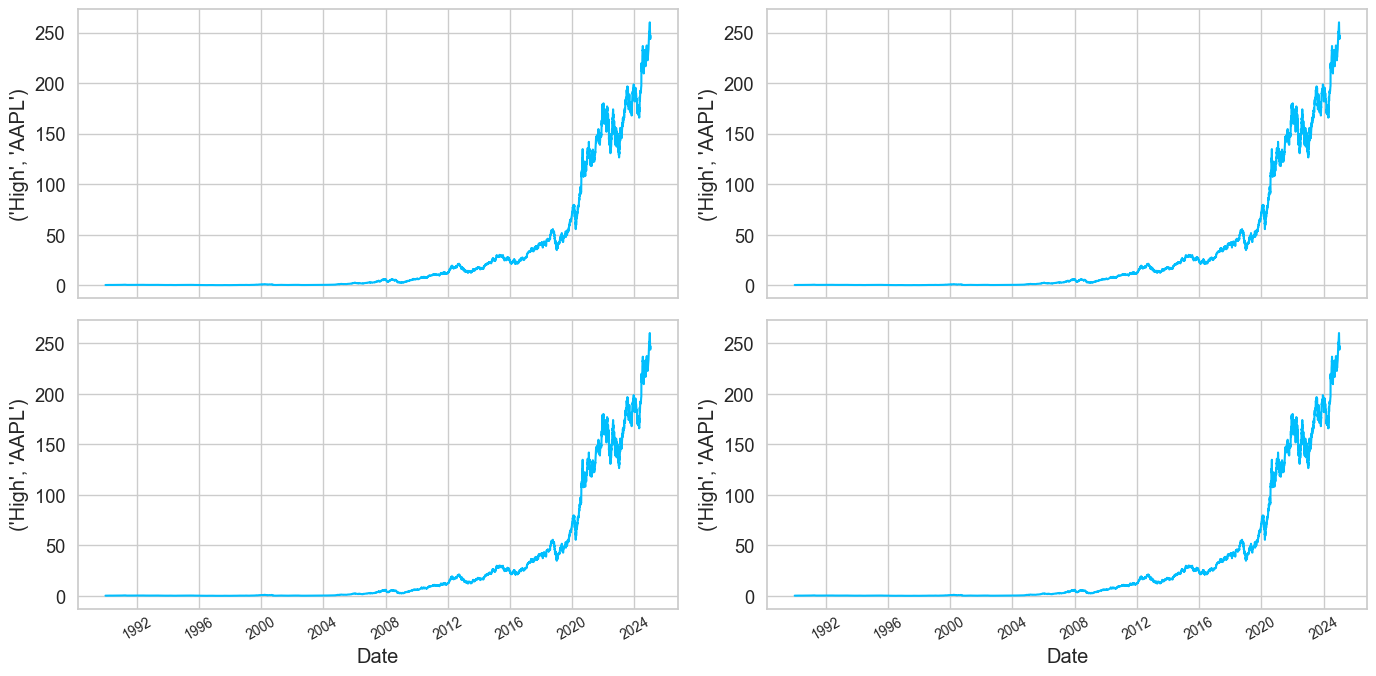

In [6]:
import matplotlib.dates as mdates

def data_plot(df):
    df_plot = df.copy()
    
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols,0))
    
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,sharex=True,figsize=(14,7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:,1],ax=ax)
        ax.tick_params(axis="x",rotation=30,labelsize=10,length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()
    
data_plot(df)

### 4 Data Preprocessing
Here we split the data into training and test splits, normalize the values using `MinMaxScaler`

In [14]:
import math
from sklearn.preprocessing import MinMaxScaler

# Train test split
training_data_len = math.ceil(len(df) * .8)
print(training_data_len)

# Splitting the dataset
train_data = df[:training_data_len].iloc[:, 3:4]
test_data = df[training_data_len:].iloc[:, 3:4]
print(train_data.shape, test_data.shape)

# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])


7058
(7058, 1) (1764, 1)
(7058, 1)
(1764, 1)
[[0.00367624]
 [0.00414712]
 [0.00418992]
 [0.00410431]
 [0.00406149]]
[[0.02774781]
 [0.02869384]
 [0.02965038]
 [0.02986063]
 [0.02839953]]


### 4 Creating sequences and labels for training and testing
We structure the data into sequences for the LSTM model. Each sequence contains a specified number of time steps. 
Then convert the data into PyTorch tensors, for PyTorch model.

* **`sequence_length`:** The number of time steps the model looks back to make a prediction
* **`X_train` and `y_train`:** Tensors for input sequences and labels for training
* **`X_test` and `y_test`:** Tensors for testing data
* **torch.tensor :** Converts numpy arrays into PyTorch tensors

In [16]:
sequence_length = 50
X_train,y_train = [],[]
for i in range(len(scaled_train)-sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+sequence_length]) #predicting the value right after the sequence
X_train,y_train = np.array(X_train),np.array(y_train)

#Convert np arrays into tensors
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
print(X_train.shape,y_train.shape)


#for testing data
sequence_length = 30
X_test,y_test = [],[]
for i in range(len(scaled_test)-sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+sequence_length])
X_test,y_test = np.array(X_test), np.array(y_test)

X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([7008, 50, 1]) torch.Size([7008, 1])
torch.Size([1734, 30, 1]) torch.Size([1734, 1])


### 6 Define and train the LSTM Model
Define an LSTM model for time series forecasting. The model include an LSTM layer, followed by a fully connected layer
We will then train and evaluate the model on the test data. 
* **LSTMModel:** A PyTorch neural network class with an LSTM layer and a linear layer.
* **Device Config:** Check if GPU is available and use it if possible. 
* **Hyperparameters:** Settings like input size,hidden size, number of layers, dropout rate, batch size, learning rate, num of epochs.
* **DataLoader:** Utility to handle batching and shuffling of the dataset.
* **Training Loop:** Loop over the dataset for a specified number of epochs, performing forward and backward passes and updating model weights.

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size,hidden_size,num_layers,dropout=0.2):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=dropout)
        self.linear = nn.Linear(hidden_size,1)
        
    def forward(self,x):
        out,_ = self.lstm(x)
        out = self.linear(out[:,-1,:])
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2

model = LSTMModel(input_size,hidden_size,num_layers,dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(),lr=1e-3)

batch_size = 32
train_dataset = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = TensorDataset(X_test,y_test)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

num_epochs = 100
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X,batch_y in train_loader:
        batch_X,batch_y = batch_X.to(device),batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions,batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
    
    model.eval()
    with torch.inference_mode():
        total_test_loss = 0.0

        for batch_X_test,batch_y_test in test_loader:
            batch_X_test,batch_y_test = batch_X_test.to(device),batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test,batch_y_test)
            
            total_test_loss += test_loss.item()
        
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    
    if(epoch + 1) % 10 == 0:
        print(f"Epoch[{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss}")

cpu
Epoch[10/100] - Training Loss: 0.0002, Test Loss: 0.0005987400546886916
Epoch[20/100] - Training Loss: 0.0002, Test Loss: 0.0005251578317752733
Epoch[30/100] - Training Loss: 0.0001, Test Loss: 0.00045456708718451076
Epoch[40/100] - Training Loss: 0.0001, Test Loss: 0.00022172909572294554
Epoch[50/100] - Training Loss: 0.0001, Test Loss: 0.000368185645179024
Epoch[60/100] - Training Loss: 0.0001, Test Loss: 0.0001685069773223156
Epoch[70/100] - Training Loss: 0.0001, Test Loss: 0.00016680893401247555
Epoch[80/100] - Training Loss: 0.0001, Test Loss: 0.00019084996853383597
Epoch[90/100] - Training Loss: 0.0001, Test Loss: 0.00022133190124639607
Epoch[100/100] - Training Loss: 0.0001, Test Loss: 0.0001937232077828164


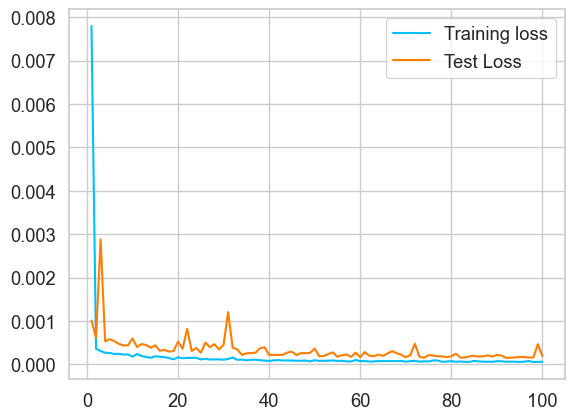

In [19]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True,label="Training loss")
plt.plot(x,test_hist,label="Test Loss")
plt.legend()
plt.show()

### 7. Predicting Future Values and Model Evaluation
Using the trained model to forecast future values. Evaluate the model's performance using metrics like RMSE and R² score.
* **Forecasting:** Generates future values using the trained model.
* **Plotting:** Visualizing the actual and forecasted values.
* **Evaluation:** Calculate RMSE and R² score to evaluate the model's performance.

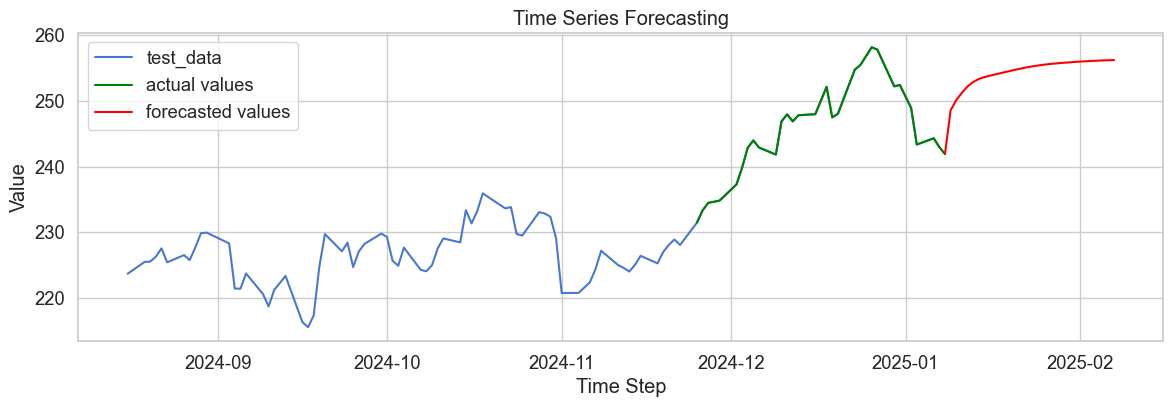

RMSE: 0.0136
R² Score: 0.9973


In [26]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Open[-100:], label="test_data", color="b")
plt.plot(test_data.index[-30:], test_data.Open[-30:], label='actual values', color='green')
 
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data.Open[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')
